In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import a_matrix_analysis_lib as mat_ansys
import b_spin_representations as su2
import c_evs_visualization_tools as evs_visz_tools
import d_projected_evolution_dynamics as me
import e_Hierarchical_Basis_Evs as HBProjEv

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [91]:
N=6; chain_type = "XX"; k_B = 1; temp = 1e-1; temp_ref = 2e0

### One body local spin operators
spin_ops_list = su2.one_body_spin_ops(size = N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
Hamiltonian_paras = [-1e0, -2.5e0, 0., 1e-1]
H_H = su2.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                           size = N, Hamiltonian_paras = Hamiltonian_paras,
                                           closed_bcs = True, visualization = False)

### Some observables of interest

cl_ops, label_ops = su2.classical_ops(size = N, Hamiltonian = H_H,
                                                op_list = spin_ops_list, centered_x_op = False)

magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
cl_ops["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; label_ops.append("n_oc_op_sq")

print("Are all the operators Hermitian?:", mat_ansys.basis_hermitian_check(basis = cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True, True]


In [92]:
# solo algunos observables
subset_of_observables = {}; subset_label_ops = []
#subset_of_observables["x_op"] = cl_ops["x_op"]; subset_label_ops.append("x_op")
subset_of_observables["x_op_sq"] = cl_ops["x_op"]**2; subset_label_ops.append("x_op_sq")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")
subset_of_observables["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; subset_label_ops.append("n_oc_op_sq")
#subset_of_observables["p_op"] = cl_ops["p_op"]; subset_label_ops.append("p_op")
#subset_of_observables["magnetization"] = cl_ops["magnetization"]; subset_label_ops.append("magnetization")#

In [93]:
beta_ref = (1/temp_ref); coeff_lambda = 1.25; coeff_sigma = .5

calB_basis_0 = [identity_op, H_H, cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"]]
coeff_basis_t0 = [0, beta_ref * (1-coeff_lambda), -beta_ref * 2 * coeff_lambda, beta_ref * coeff_lambda, beta_ref * coeff_sigma]

K_ref = -sum(coeff_basis_t0[a] * calB_basis_0[a] for a in range(len(calB_basis_0)))
rho_ref = K_ref.expm()
coeff_basis_t0[0] = np.log(rho_ref.tr())
K_ref = -sum(coeff_basis_t0[a] * calB_basis_0[a] for a in range(len(calB_basis_0)))
rho_ref = rho_ref/rho_ref.tr()

assert mat_ansys.is_density_op(rho_ref), "Reference state not a density operator"

calB_basis_0.pop()
range_derived_series_orders = depth_parameters = [1, 3, 6]
all_coeff_list = [coeff_basis_t0 + list(np.zeros(a)) for a in depth_parameters]

# en ell = 0, estoy metiendo a x_op
# en ell = 1, estoy metiendo a x_op y un commutador
# en ell = 3, estoy metiendo a x_op y a tres commutadores
# en ell = 6, estoy metiendo a x_op y a seis commutador
### n_oc_op tiene que tener una ocupacion igual a 1, no 3 xd

In [94]:
linalg.norm(mat_ansys.commutator(rho_ref, H_H))

0.27736097872287324

In [95]:
all_coeff_list

[[3.838005437151988, -0.125, -1.25, 0.625, 0.25, 0.0],
 [3.838005437151988, -0.125, -1.25, 0.625, 0.25, 0.0, 0.0, 0.0],
 [3.838005437151988, -0.125, -1.25, 0.625, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

## XX chain

Processing step:  1  and hierarchical basis of l=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 6
    |▼| 2. using a base of size  6
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3a. using rho0 = rho_ref
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynamics Succesfully Concluded.
    |▼| 6b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of l=  3
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 8
    |▼| 2. using a base of size  8
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3a. using rho0 = rho_ref
    |▼| 3b. constructing rho0 from the coeff. list and

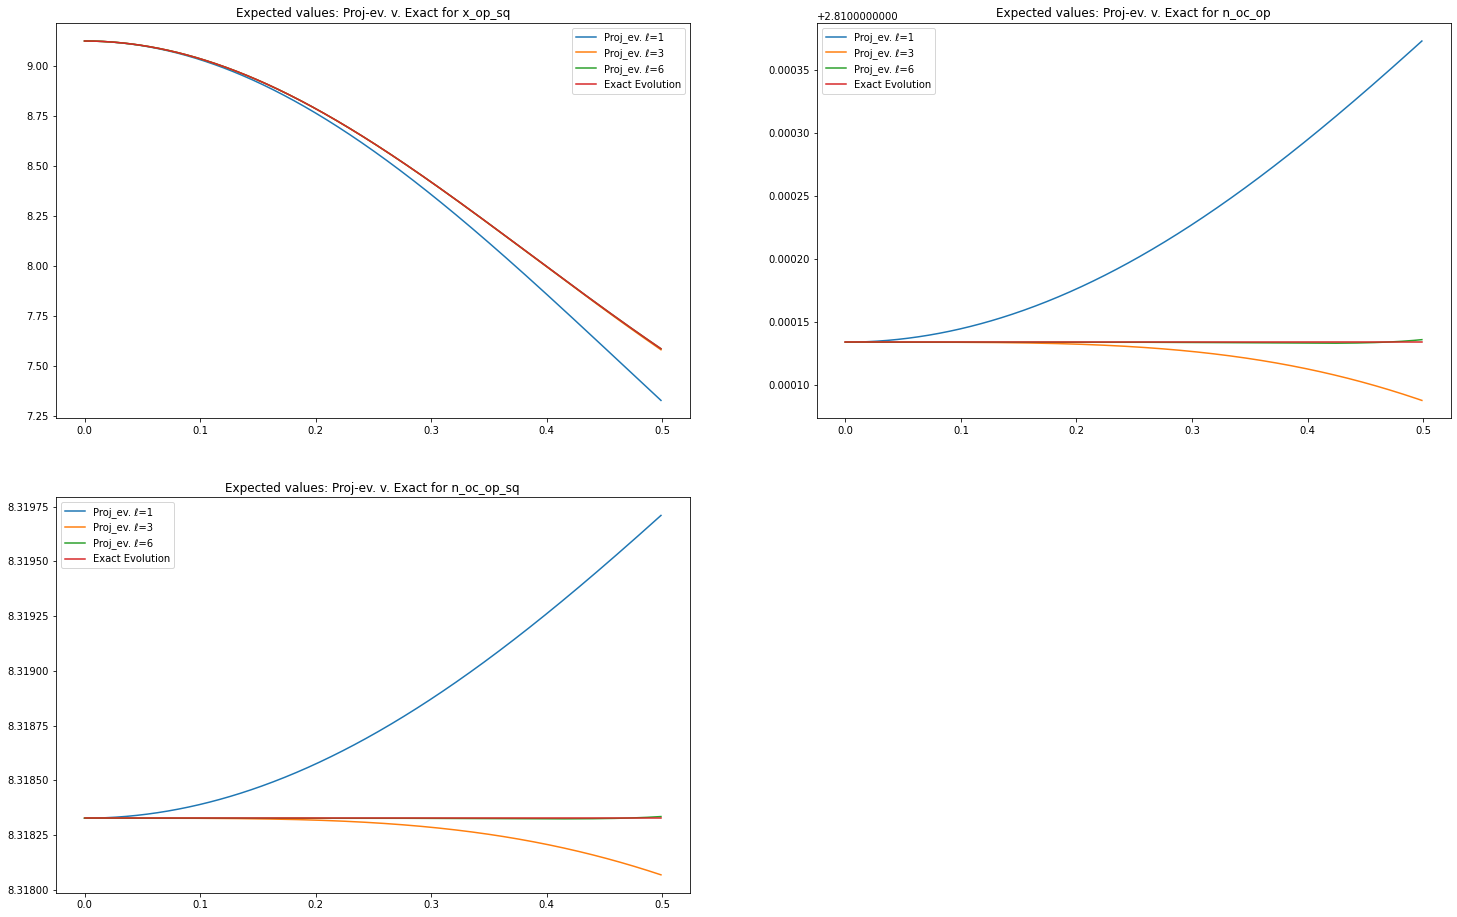

In [96]:
ts = np.linspace(1e-5, 0.5, 500)

resultados = HBProjEv.HierarchBasis_vardim_proj_evs(Hamiltonian = H_H, fixed_ops_list = calB_basis_0,
                                                    rho_ref = rho_ref, 
                                                    range_derived_series_orders = depth_parameters, 
                                                     temp_ref = temp_ref, temp_rho = temp,
                                                     generating_operator = cl_ops["x_op"],
                                                     init_coeff_list = all_coeff_list,
                                                     timespan = ts, label_ops = subset_label_ops,
                                                     observables = list(subset_of_observables.values()),
                                                     rho_ref_equal_rho0 = True)

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                          plot_var_HierarchBases_dim = True)

#metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
#                                                            range_of_temps_or_dims = range_derived_series_orders,
#                                                                  multiple_evolutions = resultados,
#                                                plot_var_HierarchBases_dim = True)

#evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
#                                                     range_of_temps_or_dims = range_derived_series_orders,
#                                                     metric_local = metrics,
 #                                         plot_var_HierarchBases_dim = True)

In [19]:
### Test: 
rho0_HB0 = resultados["init_configs_all"]["init_configs_HierarchBases0"]["rho0"]
rho0_HB1 = resultados["init_configs_all"]["init_configs_HierarchBases1"]["rho0"]
rho0_HB2 = resultados["init_configs_all"]["init_configs_HierarchBases2"]["rho0"]
rho0_exact = resultados["res_exact_all"]["res_exact_HierarchBases2"].states[0]

print(r'Are all initial states, $\rho_0$, equal for all evolutions?')
rho0_HB0 == rho0_HB1 == rho0_HB2 == rho0_exact

Are all initial states, $\rho_0$, equal for all evolutions?


True

In [20]:
n_oc_op_HB0 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases0"]["Avgs"][1]
n_oc_op_HB1 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases1"]["Avgs"][1]
n_oc_op_HB2 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases2"]["Avgs"][1]
n_oc_op_exact = resultados["res_exact_all"]["res_exact_HierarchBases2"].expect[1]
res_n_evs = [n_oc_op_exact[:-1], n_oc_op_HB0, n_oc_op_HB1, n_oc_op_HB2]

n_oc_op_sq_HB0 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases0"]["Avgs"][2]
n_oc_op_sq_HB1 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases1"]["Avgs"][2]
n_oc_op_sq_HB2 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases2"]["Avgs"][2]
n_oc_op_sq_exact = resultados["res_exact_all"]["res_exact_HierarchBases2"].expect[2]
res_n_sq_evs = [n_oc_op_sq_exact, n_oc_op_sq_HB0, n_oc_op_sq_HB1, n_oc_op_sq_HB2]

In [45]:
n_oc_std_exact = [(n_oc_op_exact[m]**2 - n_oc_op_sq_exact[m]) for m in range(len(n_oc_op_sq_exact))]
n_oc_std_HB0 = [(n_oc_op_HB0[m]**2 - n_oc_op_sq_HB0[m]) for m in range(len(n_oc_op_sq_HB0))]
n_oc_std_HB1 = [(n_oc_op_HB1[m]**2 - n_oc_op_sq_HB1[m]) for m in range(len(n_oc_op_sq_HB1))]
n_oc_std_HB2 = [(n_oc_op_HB2[m]**2 - n_oc_op_sq_HB2[m]) for m in range(len(n_oc_op_sq_HB2))]

n_oc_std_all_evs = [n_oc_std_exact[:-1], n_oc_std_HB0, n_oc_std_HB1, n_oc_std_HB2]
labels = ["Ex", "HB0  ℓ=1", "HB1  ℓ=3", "HB2  ℓ=6"]

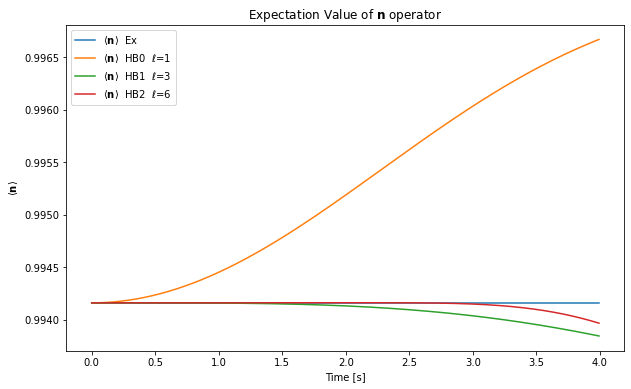

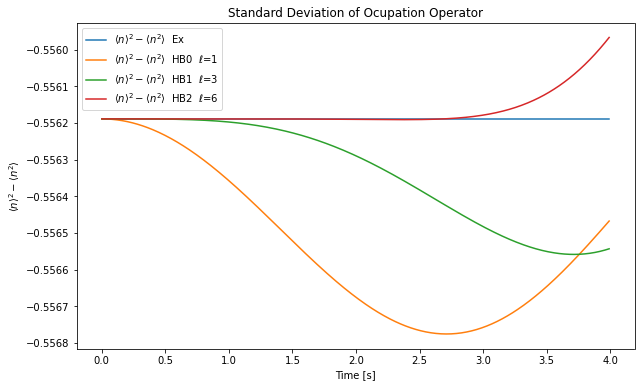

In [75]:
fig0, ax0 = plt.subplots(figsize=(10,6))

for n in range(len(n_oc_std_all_evs)):
    plt.plot(ts[:-1], res_n_evs[n], label = r'$\langle {\bf n} \rangle$' + "  " + labels[n])

#plt.ylim(.9940, .9945)
ax0.legend(loc=0)
ax0.set_xlabel(r'Time [s]')
ax0.set_ylabel(r'$\langle {\bf n} \rangle$')
ax0.set_title(r'Expectation Value of ${\bf n}$ operator');

fig, ax = plt.subplots(figsize=(10,6))

for n in range(len(n_oc_std_all_evs)):
    plt.plot(ts[:-1], n_oc_std_all_evs[n], label = r'$\langle n \rangle^2 - \langle n ^2\rangle$' + "  " + labels[n])
    
ax.legend(loc=0)
ax.set_xlabel(r'Time [s]')
ax.set_ylabel(r'$\langle n \rangle^2 - \langle n ^2\rangle$')
ax.set_title(r'Standard Deviation of Ocupation Operator');

(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

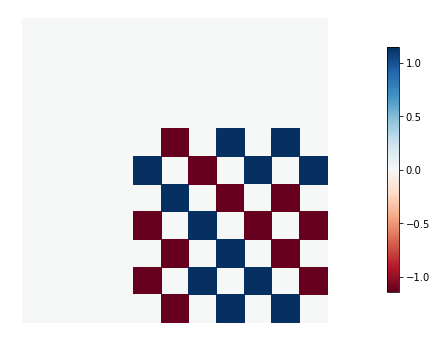

In [90]:
qutip.hinton(H_tensor_2)

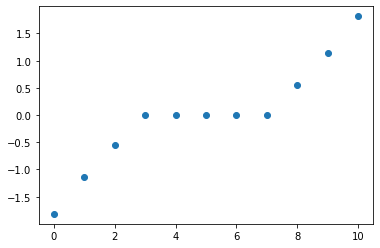

In [92]:
plt.scatter(range(11),sorted(qutip.Qobj(1j*H_tensor_2).eigenenergies()))

## FFT de los observables XX

Processing step:  1  and hierarchical basis of l=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 6
    |▼| 2. using a base of size  6
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynamics Succesfully Concluded.
    |▼| 6b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of l=  3
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 8
    |▼| 2. using a base of size  8
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the

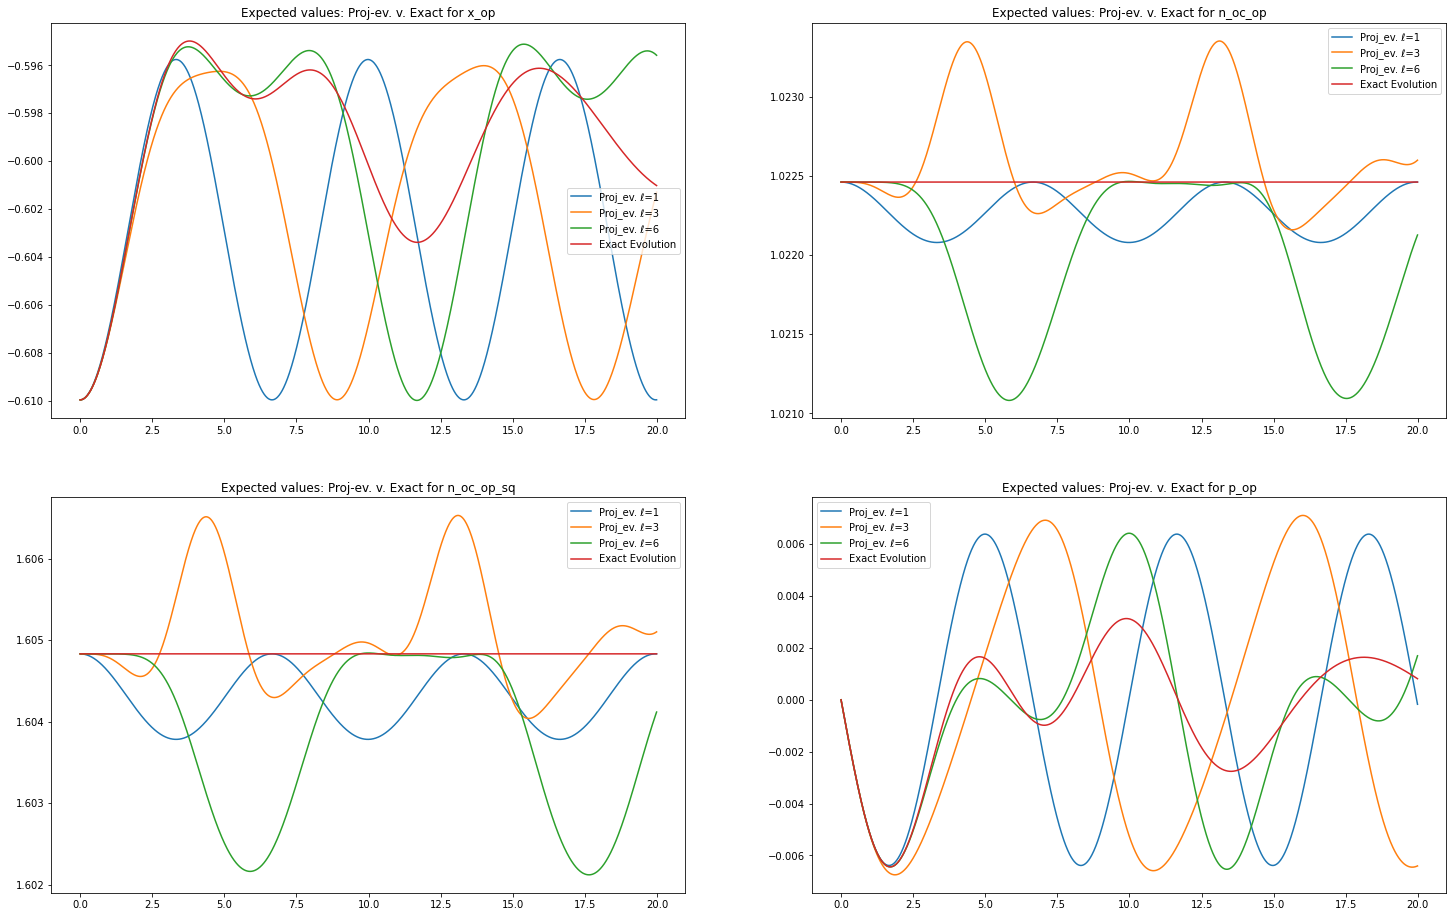

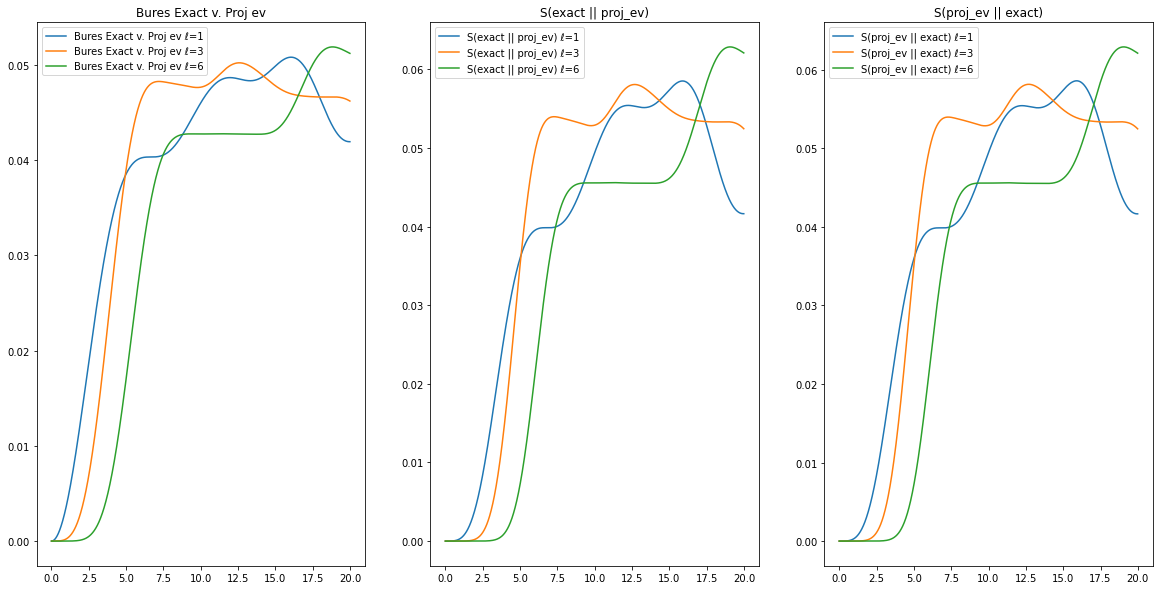

In [37]:
# N = 6, XX
#ts = np.linspace(1e-5, 2.0, 500)
ts = np.linspace(1e-5, 20.0, 1500)

resultados = HBProjEv.HierarchBasis_vardim_proj_evs(Hamiltonian = H_H, fixed_ops_list = fixed_ops_list,
                                                    rho_ref = custom_rho_ref, 
                                              range_derived_series_orders = range_derived_series_orders, 
                                     temp_ref = temp_ref, temp_rho = temp,
                                     generating_operator = spin_ops_list[1][0],
                                     init_coeff_list = all_coeff_lists,
                                     timespan = ts, label_ops = subset_label_ops,
                                     observables = list(subset_of_observables.values()),
                                     rho_ref_equal_rho0 = False)

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                          plot_var_HierarchBases_dim = True)

metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = range_derived_series_orders,
                                                                  multiple_evolutions = resultados,
                                                plot_var_HierarchBases_dim = True)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = range_derived_series_orders,
                                                     metric_local = metrics,
                                          plot_var_HierarchBases_dim = True)

In [38]:
avsg_xop_sq_exact = resultados["res_exact_all"]['res_exact_HierarchBases2'].expect[0][:-1]
avgs_xop_sq_HB0 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases0"]["Avgs"][0]
avgs_xop_sq_HB1 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases1"]["Avgs"][0]
avgs_xop_sq_HB2 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases2"]["Avgs"][0]

avsg_xop_sq_exact = resultados["res_exact_all"]['res_exact_HierarchBases2'].expect[0][:-1]
avgs_xop_sq_HB0 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases0"]["Avgs"][0]
avgs_xop_sq_HB1 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases1"]["Avgs"][0]
avgs_xop_sq_HB2 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases2"]["Avgs"][0]

freq_fft = np.fft.fftfreq(ts.shape[-1])
#freq_plot = [freq_fft[t] for t in range(len(freq_fft)) if (t <= -0.2 or t >= 0.2)]
freq_plot = freq_fft
freqs_fft_avgs_x_op_exact = np.fft.fft(avsg_xop_sq_exact)[1:]
freqs_fft_avgs_x_op_hb1 = np.fft.fft(avgs_xop_sq_HB0)[1:]
freqs_fft_avgs_x_op_hb3 = np.fft.fft(avgs_xop_sq_HB1)[1:]
freqs_fft_avgs_x_op_hb6 = np.fft.fft(avgs_xop_sq_HB2)[1:]

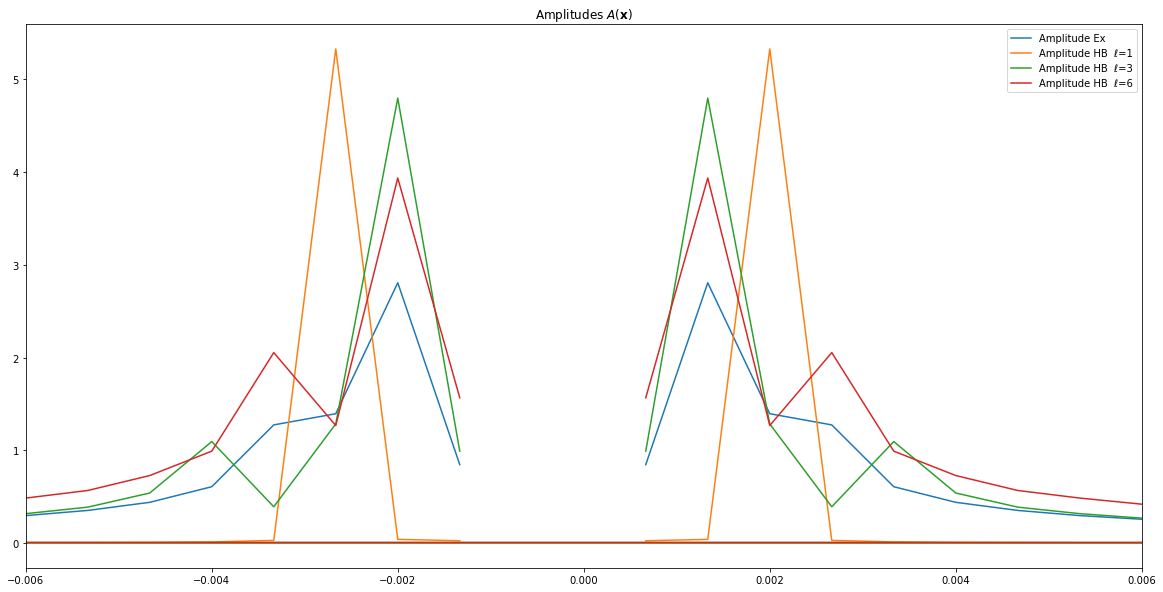

In [39]:
fig = plt.figure(figsize=(20, 10))
plt.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_x_op_exact.real + 1j * freqs_fft_avgs_x_op_exact.imag), label = "Amplitude Ex")
plt.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_x_op_hb1.real + 1j * freqs_fft_avgs_x_op_hb1.imag), label = "Amplitude HB  ℓ=1")
plt.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_x_op_hb3.real + 1j * freqs_fft_avgs_x_op_hb3.imag), label = "Amplitude HB  ℓ=3")
plt.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_x_op_hb6.real + 1j * freqs_fft_avgs_x_op_hb6.imag), label = "Amplitude HB  ℓ=6")
plt.xlim(-.006, .006)
plt.title(r'Amplitudes $A({\bf x})$')
plt.legend()